In [1]:
import torch as t
from torch import einsum
from einops import rearrange, reduce, repeat
import bert_tests
import transformers
import random
import math
import numpy as np

In [2]:
def raw_attention_pattern(token_activations, num_heads, project_query, project_key):
    K = rearrange(project_key(token_activations), "b s (n h) -> b s n h", n = num_heads)
    Q = rearrange(project_query(token_activations), "b s (n h) -> b s n h", n = num_heads)

    KbyQ = t.einsum("bsnh,btnh -> bnst", K, Q)

    d_k = token_activations.shape[2]/num_heads

    out = KbyQ/t.sqrt(t.tensor([d_k]))
    return out

bert_tests.test_attention_pattern_fn(raw_attention_pattern)


attention pattern raw MATCH!!!!!!!!
 SHAPE (2, 12, 3, 3) MEAN: -0.01152 STD: 0.1016 VALS [0.03246 0.09426 -0.07523 0.106 0.006123 0.1217 0.1085 0.06477 0.05628 -0.1145...]


In [3]:
def bert_attention(token_activations, num_heads, attention_pattern, project_value, project_output):
    s = t.nn.Softmax(dim=2)

    out = s(attention_pattern) # batch_size, head_num, key_token, query_token

    out = rearrange(out, "b n k q -> b n q k 1")

    V = rearrange(project_value(token_activations), "b k (n h) -> b n 1 k h", n = num_heads) # batch_size, num_heads, 1, key, head_size

    out = einsum("bnqkh,bnqkh -> bnqh", out, V)

    out = rearrange(out, "b n q h -> b q (n h)")

    return project_output(out)

bert_tests.test_attention_fn(bert_attention)



attention MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.0024 STD: 0.1174 VALS [-0.08224 0.05514 0.02298 -0.08445 -0.03101 0.06312 -0.1459 -0.09142 -0.04613 -0.04548...]


In [4]:
class MultiHeadedSelfAttention(t.nn.Module):
    def __init__(self, num_heads, hidden_size):
        super(MultiHeadedSelfAttention, self).__init__()

        hidden_dim = num_heads * hidden_size

        self.query = t.nn.Linear(hidden_size, hidden_size)
        self.key = t.nn.Linear(hidden_size, hidden_size)
        self.value = t.nn.Linear(hidden_size, hidden_size)
        self.output = t.nn.Linear(hidden_size, hidden_size)

        self.num_heads = num_heads
        self.hidden_size = hidden_size

    def forward(self, input):
        attention_scores = raw_attention_pattern(input, self.num_heads, self.query, self.key)

        attention = bert_attention(input, self.num_heads, attention_scores, self.value, self.output)

        return attention

bert_tests.test_bert_attention(MultiHeadedSelfAttention)

        

bert MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.001554 STD: 0.1736 VALS [-0.08316 -0.09165 -0.03188 -0.03013 0.1001 0.09549 -0.1046 0.07742 0.0424 0.05553...]


In [5]:
def bert_mlp(token_activations, linear_1, linear_2):
    out = linear_1(token_activations)
    out = t.nn.GELU()(out)
    return linear_2(out)

bert_tests.test_bert_mlp(bert_mlp)


bert mlp MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -0.0001934 STD: 0.1044 VALS [-0.1153 0.1189 -0.0813 0.1021 0.0296 0.06182 0.0341 0.1446 0.2622 -0.08507...]


In [6]:
class BertMLP(t.nn.Module):
    def __init__(self, input_size, intermediate_size):
        super(BertMLP, self).__init__()
        self.linear_1 = t.nn.Linear(input_size,intermediate_size)
        self.linear_2 = t.nn.Linear(intermediate_size,input_size)
    
    def forward(self,input):
        return bert_mlp(input,self.linear_1,self.linear_2)



In [7]:
class LayerNorm(t.nn.Module):
    def __init__(self, normalized_dim):
        super().__init__()
        self.weight = t.nn.Parameter(t.ones((normalized_dim,)))
        self.bias = t.nn.Parameter(t.zeros((normalized_dim,)))
    
    def forward(self, input):
        eps = 1e-05
        mean = input.mean(-1).unsqueeze(-1)
        mean.detach()
        stdev = input.std(-1,unbiased = False).unsqueeze(-1)
        stdev.detach()
        out = (input - mean)/t.sqrt(stdev**2 + eps) 
        return out*self.weight + self.bias
bert_tests.test_layer_norm(LayerNorm)



layer norm MATCH!!!!!!!!
 SHAPE (20, 10) MEAN: -9.537e-09 STD: 1.003 VALS [0.6906 -0.84 1.881 1.711 -0.5116 -0.9577 -0.1387 -0.6943 -0.6741 -0.4662...]


In [8]:
class BertBlock(t.nn.Module):
    def __init__(self, hidden_size, intermediate_size, num_heads, dropout):
        super().__init__()
        self.mhsa = MultiHeadedSelfAttention(num_heads, hidden_size)
        self.layer_norm1 = LayerNorm(hidden_size)
        self.mlp = BertMLP(hidden_size, intermediate_size)
        self.layer_norm2 = LayerNorm(hidden_size)
        self.dropout = t.nn.Dropout(dropout)

    def forward(self, input):
        out = self.mhsa(input)
        out = self.layer_norm1(input + out)
        residual = out
        out = self.mlp(out)
        out = self.dropout(out)
        out = self.layer_norm2(residual + out)
        return out

bert_tests.test_bert_block(BertBlock)



bert MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: -2.484e-09 STD: 1 VALS [0.007132 -0.04372 0.6502 -0.5972 -1.097 0.7267 0.1275 -0.6035 -0.2226 0.2145...]


In [9]:
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
print(tokenizer(['Hello, I am a sentence.']))

{'input_ids': [[101, 8667, 117, 146, 1821, 170, 5650, 119, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [10]:
class Embedding(t.nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.embedding = t.nn.Parameter(t.randn((vocab_size, embed_size)))

    def forward(self, input):
        return self.embedding[input]

bert_tests.test_embedding(Embedding)

embedding MATCH!!!!!!!!
 SHAPE (2, 3, 5) MEAN: -0.06748 STD: 1.062 VALS [1.176 -0.1914 0.8212 1.047 -0.481 0.7106 -1.304 -1.307 -0.438 -0.2764...]


In [11]:
def bert_embedding(input_ids, token_type_ids, position_embedding, token_embedding, token_type_embedding, layer_norm, dropout):        
    positions = repeat(t.arange(input_ids.shape[1]), "p -> b p", b = input_ids.shape[0])
    
    if input_ids.is_cuda:
        device = input_ids.get_device()
        positions.to(device = device)
    
    out = token_embedding(input_ids) + token_type_embedding(token_type_ids) + position_embedding(positions)
    out = layer_norm(out)
    return dropout(out)

bert_tests.test_bert_embedding_fn(bert_embedding)

bert embedding MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: 8.278e-10 STD: 1 VALS [-1.319 -0.4378 -2.074 0.9679 0.9274 1.479 -0.501 -1.9 -0.212 0.7961...]


In [12]:
class BertEmbedding(t.nn.Module):
    def __init__(self, vocab_size, hidden_size, max_position_embeddings, type_vocab_size, dropout):
        super().__init__()
        self.token_embedding = Embedding(vocab_size, hidden_size)
        self.position_embedding = Embedding(max_position_embeddings, hidden_size)
        self.token_type_embedding = Embedding(type_vocab_size, hidden_size)
        self.layer_norm = LayerNorm(hidden_size)
        self.dropout = t.nn.Dropout(dropout)
 
    def forward(self, input_ids, token_type_ids=None):
        if token_type_ids is None:
            token_type_ids = t.zeros_like(input_ids)
        return bert_embedding(input_ids, token_type_ids, self.position_embedding, self.token_embedding, self.token_type_embedding, self.layer_norm, self.dropout)

bert_tests.test_bert_embedding(BertEmbedding)


bert embedding MATCH!!!!!!!!
 SHAPE (2, 3, 768) MEAN: 2.69e-09 STD: 1 VALS [-0.009385 -0.4919 0.9852 -0.3535 -3.624 1.333 1.163 1.449 1.063 0.246...]


In [13]:
class Bert(t.nn.Module):
    def __init__(self, vocab_size, hidden_size, max_position_embeddings, type_vocab_size, dropout, intermediate_size, num_heads, num_layers):
        super().__init__()

        self.model = t.nn.Sequential(
            BertEmbedding(vocab_size, hidden_size, max_position_embeddings, type_vocab_size, dropout),
            *[BertBlock(hidden_size, intermediate_size, num_heads, dropout) for _ in range(num_layers)],
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.GELU(),
            LayerNorm(hidden_size),
            t.nn.Linear(hidden_size, vocab_size),
        )

    def forward(self, input_ids):
        token_type_ids = t.zeros_like(input_ids)
        return self.model(input_ids)

bert_tests.test_bert(Bert)

bert MATCH!!!!!!!!
 SHAPE (1, 4, 28996) MEAN: 0.003031 STD: 0.5765 VALS [-0.5742 -0.432 0.1186 -0.7165 -0.5261 0.4967 1.223 0.3165 -0.3247 -0.5716...]


In [14]:
class BertClassification(t.nn.Module):
    def __init__(self, vocab_size, hidden_size, max_position_embeddings, type_vocab_size, dropout, intermediate_size, num_heads, num_layers, num_classes):
        super().__init__()
        self.embedding = BertEmbedding(vocab_size, hidden_size, max_position_embeddings, type_vocab_size, dropout)
        self.transformer = t.nn.Sequential(*[BertBlock(hidden_size, intermediate_size, num_heads, dropout) for _ in range(num_layers)])
        self.lmhead = t.nn.Sequential(
            t.nn.Linear(hidden_size, hidden_size),
            t.nn.GELU(),
            LayerNorm(hidden_size)
        )
        self.dropout = t.nn.Dropout(dropout)
        self.unembedding = t.nn.Linear(hidden_size, vocab_size)
        self.classification_head = t.nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):
        out = self.embedding(input_ids)

        out = self.transformer(out)

        logits = self.lmhead(out)
        logits = self.unembedding(logits)

        out = self.dropout(out)

        out = out[:,0,:]

        print('Pre-classification out', out.shape)

        out = self.classification_head(out)

        print('Post-classification out', out.shape)

        return (logits, out)

bert_tests.test_bert_classification(BertClassification)

Pre-classification out torch.Size([1, 768])
Post-classification out torch.Size([1, 2])
bert MATCH!!!!!!!!
 SHAPE (1, 4, 28996) MEAN: 0.003031 STD: 0.5765 VALS [-0.5742 -0.432 0.1186 -0.7165 -0.5261 0.4967 1.223 0.3165 -0.3247 -0.5716...]
bert MATCH!!!!!!!!
 SHAPE (1, 2) MEAN: 0.09479 STD: 1.411 VALS [-0.903 1.093]


In [15]:
my_bert = BertClassification(
    vocab_size=28996, hidden_size=768, max_position_embeddings=512, 
    type_vocab_size=2, dropout=0.1, intermediate_size=3072, 
    num_heads=12, num_layers=12, num_classes = 2,
)
pretrained_bert = bert_tests.get_pretrained_bert()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
import re

def mapkey(key):

    # embedding = model.0
    # key = re.sub(r'^embedding', 'bert.model.0', key)

    # transformer.i = model.(i+1)
    # key = re.sub(r'transformer\.(\d+)', lambda expr: "bert.model.{}".format(int(expr.groups()[0]) + 1), key)

    # attention = mhsa
    key = re.sub('.attention.', '.mhsa.', key)

    key = re.sub('lm_head.mlp', 'lmhead.0', key)
    key = re.sub('lm_head.unembedding', 'unembedding', key)
    key = re.sub('lm_head.layer_norm', 'lmhead.2', key)

    key = re.sub('_embedding.weight', '_embedding.embedding', key)

    key = re.sub(r'pattern\.project_(key|query)', lambda expr: "{}".format(expr.groups()[0]), key)

    key = re.sub('project_out', 'output', key)
    key = re.sub('project_value', 'value', key)

    key = re.sub(r'residual\.mlp(1|2)', lambda expr: "mlp.linear_{}".format(expr.groups()[0]), key)

    # key = re.sub(r'^((?!residual).)*\.layer_norm', 'layer_norm1', key)
    key = re.sub(r'residual\.layer_norm', 'layer_norm2', key)
    key = re.sub(r'layer_norm\.', 'layer_norm1.', key)

    key = re.sub(r'embedding\.layer_norm1', 'embedding.layer_norm', key)

    # key = re.sub(r'model\.15', 'model.temp', key)
    # key = re.sub(r'model\.16', 'model.15', key)
    # key = re.sub(r'model\.temp', 'model.16',key)

    key = re.sub(r'^model', "transformer", key)


    return key

mapkey('embedding gesgse')
mapkey('transformer.1')
mapkey('.attention.')

# False 15 model.1.mlp.linear_1.weight model.1.residual.mlp1.weight
# False 16 model.1.mlp.linear_1.bias model.1.residual.mlp1.bias


def matching(xs, pattern):
    return [s for s in xs if re.search(pattern, s)]

matching(list(pretrained_bert.state_dict()), 'layer_norm')



['embedding.layer_norm.weight',
 'embedding.layer_norm.bias',
 'transformer.0.layer_norm.weight',
 'transformer.0.layer_norm.bias',
 'transformer.0.residual.layer_norm.weight',
 'transformer.0.residual.layer_norm.bias',
 'transformer.1.layer_norm.weight',
 'transformer.1.layer_norm.bias',
 'transformer.1.residual.layer_norm.weight',
 'transformer.1.residual.layer_norm.bias',
 'transformer.2.layer_norm.weight',
 'transformer.2.layer_norm.bias',
 'transformer.2.residual.layer_norm.weight',
 'transformer.2.residual.layer_norm.bias',
 'transformer.3.layer_norm.weight',
 'transformer.3.layer_norm.bias',
 'transformer.3.residual.layer_norm.weight',
 'transformer.3.residual.layer_norm.bias',
 'transformer.4.layer_norm.weight',
 'transformer.4.layer_norm.bias',
 'transformer.4.residual.layer_norm.weight',
 'transformer.4.residual.layer_norm.bias',
 'transformer.5.layer_norm.weight',
 'transformer.5.layer_norm.bias',
 'transformer.5.residual.layer_norm.weight',
 'transformer.5.residual.layer_no

In [17]:
pretrained_params = list(pretrained_bert.state_dict())

# for i, our_param in enumerate(my_bert.state_dict()):
#     print(our_param == mapkey(pretrained_params[i]), i, our_param, mapkey(pretrained_params[i]))

for pretrained_param in pretrained_bert.state_dict():
    if mapkey(pretrained_param) not in my_bert.state_dict():
        print(mapkey(pretrained_param))

# for i, our_param in enumerate(my_bert.state_dict()):
#     print(our_param, pretrained_params[i])


# print(list(pretrained_bert.state_dict()))
# print(list(my_bert.state_dict()))

In [18]:
new_state_dict = {}

for pretrained_param in pretrained_bert.state_dict():
    new_state_dict[mapkey(pretrained_param)] = pretrained_bert.state_dict()[pretrained_param]

my_bert.load_state_dict(new_state_dict)

<All keys matched successfully>

In [19]:
bert_tests.test_same_output(my_bert, pretrained_bert)

Pre-classification out torch.Size([10, 768])
Post-classification out torch.Size([10, 2])


TypeError: allclose(): argument 'input' (position 1) must be Tensor, not tuple

# Fine Tuning on Classification

In [20]:
import torchtext

data_train = torchtext.datasets.IMDB(root='.data',split='train')
data_test = torchtext.datasets.IMDB(root='.data',split='test')

In [21]:
dataset_train = []
for d in data_train:
    dataset_train.append(d)

dataset_test = []
for d in data_test:
    dataset_test.append(d)

In [22]:
def extract_batches(dataset, batch_size=4, max_seq_length=512):
    # data = []
    # for d in dataset:
    #     data.append(d)    

    dataset.sort(key=lambda x: len(x[1]))

    number_of_batches = math.ceil(len(dataset) / batch_size)

    dataset = np.array_split(dataset, number_of_batches)

    batches = []

    for batch in dataset:
        scores, reviews = zip(*batch)

        tokens = tokenizer(list(reviews))

        # print(len(tokens['input_ids'][0]))
        tokens = tokens["input_ids"]

        tokens = [review_token[:max_seq_length] for review_token in tokens]
        tokens = [review_token if len(review_token) == max_seq_length else review_token + (max_seq_length - len(review_token))*[tokenizer.pad_token_id] for review_token in tokens]

        X = t.tensor(tokens)
        y = t.tensor([1 if s == "pos" else 0 for s in scores])

        batches.append((X,y))

    random.shuffle(batches)
    return batches


# print(len(extract_batches(dataset_train)))

0
Pre-classification out torch.Size([4, 768])
Post-classification out torch.Size([4, 2])
tensor([1, 1, 0, 0], device='cuda:0') tensor([[ 0.3361, -0.0086],
        [ 0.3001, -0.0810],
        [ 0.3455,  0.1134],
        [ 0.1969, -0.2294]], grad_fn=<AddmmBackward0>)
tensor([[0.5853, 0.4147],
        [0.5941, 0.4059],
        [0.5578, 0.4422],
        [0.6050, 0.3950]], device='cuda:0', grad_fn=<ToCopyBackward0>)
Pre-classification out torch.Size([4, 768])
Post-classification out torch.Size([4, 2])
tensor([0, 0, 0, 0], device='cuda:0') tensor([[0.0097, 0.2153],
        [0.1315, 0.0425],
        [0.1771, 0.2815],
        [0.5024, 0.2732]], grad_fn=<AddmmBackward0>)
tensor([[0.4488, 0.5512],
        [0.5222, 0.4778],
        [0.4739, 0.5261],
        [0.5571, 0.4429]], device='cuda:0', grad_fn=<ToCopyBackward0>)
Pre-classification out torch.Size([4, 768])
Post-classification out torch.Size([4, 2])
tensor([1, 1, 1, 1], device='cuda:0') tensor([[ 0.1237,  0.1334],
        [ 0.2886, -0.1136],

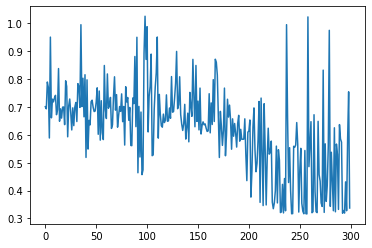

In [24]:
from matplotlib import pyplot as plt

device = t.device('cuda:0' if t.cuda.is_available() else 'cpu')

optimizer = t.optim.Adam(my_bert.parameters(), lr = 1e-5)
criterion = t.nn.CrossEntropyLoss()

steps = 300
batches = extract_batches(dataset_train)

my_bert.train()

losses = []

for i in range(steps):
    if i % 10 == 0:
        print(i)

    optimizer.zero_grad()
    X,y = batches[i]
    X = X.cuda(device)
    y = y.cuda(device)
    pred_y = my_bert(X)[1]

    pred_y = pred_y.softmax(dim=1).cuda(device)
    
    print('Actual', y)
    print('Predicted', pred_y)

    loss = criterion(pred_y, y)
    loss.backward()
    losses.append(loss.detach())
    optimizer.step()

plt.plot(losses)

# Training from Scratch on Masked Language Modelling

import torchtext

data_train = torchtext.datasets.WikiText2(root='.data',split='train')
data_test = torchtext.datasets.WikiText2(root='.data',split='test')

In [ ]:
dataset_train = []
for d in data_train:
    dataset_train.append(d)

dataset_test = []
for d in data_test:
    dataset_test.append(d)

In [ ]:
def extract_batches(dataset, batch_size=4, max_seq_length=512):

    dataset.sort(key=lambda x: len(x[1]))

    number_of_batches = math.ceil(len(dataset) / batch_size)

    dataset = np.array_split(dataset, number_of_batches)

    batches = []

    for batch in dataset:
        tokens = tokenizer(list(batch))

        tokens = tokens["input_ids"]

        tokens = [line[:max_seq_length] for line in tokens]
        tokens = [line if len(line) == max_seq_length else line + (max_seq_length - len(line))*[tokenizer.pad_token_id] for line in tokens]

        X = t.tensor(tokens)

        batches.append((X,y))

    random.shuffle(batches)
    return batches